In [1]:
using QuantumOptics
using PyPlot
using Statistics
using Random
using JLD2
using CollectiveSpins

In [2]:
""" Creates a fraction filled system by removing randomly (1-filling_fraction)*N elements from the geometry """
function fraction_filled_geometry(geometry, filling_fraction)
    N = length(geometry)

    # Choose randomly the (1-filling_fraction)*N) spins to remove from the geometry
    idx_pos_rm = randperm(N)[1:round(Int, (1-filling_fraction)*N)]
    
    geometry = geometry[setdiff(1:end, idx_pos_rm), :]
    return geometry
end

""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array, system, Nsys)
    phi_array = zeros(Nsys)
    for i = 1:Nsys
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

prepare_phi_IS

# SR criterium: Initial and max slope

### Defining the system

In [3]:
# Define the system
Nx,Ny,Nz = [5,5,1]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532.

# Define normalization variables
λ = 1299.
θl = 30*pi/180 # Angle of the laser

# Define the geometry
a_dim,b_dim,c_dim = [d_xy,d_xy,d_z]/λ
geo = CollectiveSpins.geometry.box(a_dim,b_dim,c_dim;Nx=Nx,Ny=Ny,Nz=Nz)
e = [0,0,1]   # Quantization axis

Γ0 = 1.

# Initial values
theta_init = 0#pi/2
phi_init = 0#1 # 1 if laser induced correlations between the atoms, 0 else

# Initial state
phi, theta = 0., 0.

Tstep, Tend = 1e-3, 1 # Normalised time (t/τ)
T = [0:Tstep:Tend;];

### Compute for each FF × repetition

In [4]:
repetition = 10; # Nbr of repetition per FF

In [5]:
var_FF_diff_mean_σz_mpc_rep = []
std_var_FF_diff_mean_σz_mpc_rep = []

var_FF_max_diff_mean_σz_mpc_rep = []
std_var_FF_max_diff_mean_σz_mpc_rep = []

sols_CS = []

for i = 1:N
    println(string(i)*"/"*string(N))
    var_filling_fraction = i/N
    
    diff_σz_rep = []
    max_diff_σz_rep = []
    
    for j = 1:repetition # We will average the distributions of spins over the repetition nbr
        # Remove some spins, compute the system
        geo_rep = fraction_filled_geometry(geo, var_filling_fraction)
        system_rep = CollectiveSpins.SpinCollection(geo_rep[:, 1], e, gammas=1.) # gammas normalised by γ0

        # Prepare the initial state
        theta_array = ones(i)*theta_init
        phi_array = prepare_phi_IS(θl, λ, theta_array, system_rep, i)*phi_init
        Ψ0 = CollectiveSpins.mpc.blochstate(phi_array, theta_array)
    
        ρt = CollectiveSpins.mpc.timeevolution(T, system_rep, Ψ0, dt=Tstep)[2]
        mean_σz67_CS = -1 .*([mean(CollectiveSpins.mpc.sz(ρ)) for ρ in ρt].+1) ./2 .- 6
        push!(sols_CS, mean_σz67_CS)
        push!(diff_σz_rep, diff(mean_σz67_CS)./Tstep)
        push!(max_diff_σz_rep, maximum(diff_σz_rep[end]))
    end

    # Means
    push!(var_FF_diff_mean_σz_mpc_rep, mean(diff_σz_rep))
    push!(var_FF_max_diff_mean_σz_mpc_rep, mean(max_diff_σz_rep))

    # Std
    push!(std_var_FF_diff_mean_σz_mpc_rep, std(diff_σz_rep))
    push!(std_var_FF_max_diff_mean_σz_mpc_rep, std(max_diff_σz_rep))
end

1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25


# Plots CS

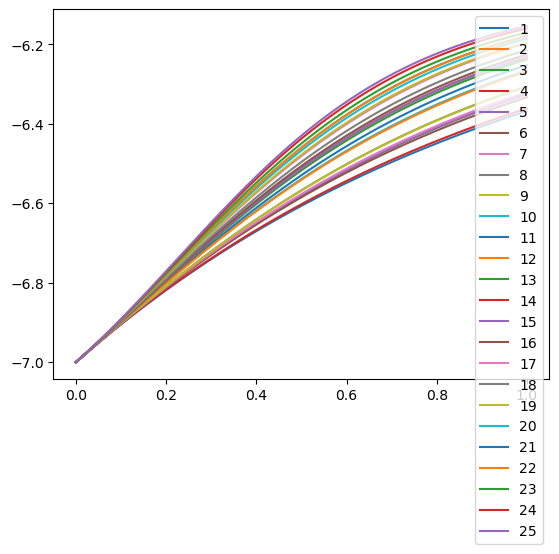

In [6]:
close("all")
figure()

for i = 1:N
    plot(T, sols_CS[i*repetition], label=i)
end

legend()
pygui(false); #gcf()

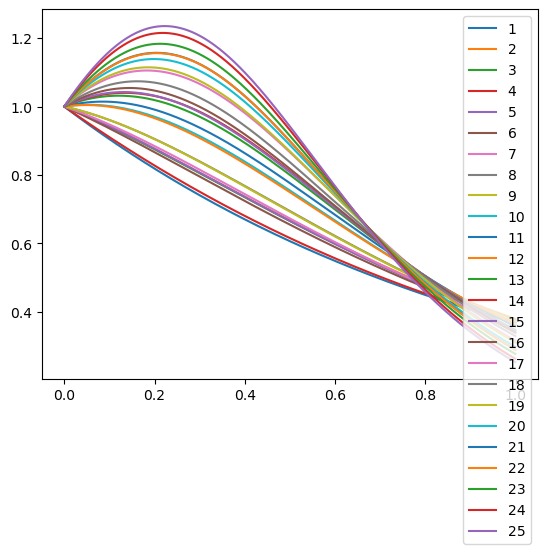

In [7]:
close("all")
figure()

for i = 1:N
    plot(T[1:end-1], diff(sols_CS[i*repetition])./Tstep, label=i)
end

legend()
pygui(false); #gcf()

# Max slope

In [8]:
# Load QC max slope
@load "VarFF_MaxSlope_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2)).jld2" var_FF_max_diff_mean_σz std_var_FF_max_diff_mean_σz sols;

In [9]:
# Recover the mean expectation values of sigmaz QC
mean_QC_sigmaz = []
counter = 1
σz_rep = []
for s in sols
    push!(σz_rep, s)
    if counter%repetition==0 && counter > 1
        push!(mean_QC_sigmaz, mean(σz_rep))
        σz_rep = []
    end
    counter +=1
end

### Plot the derivatives


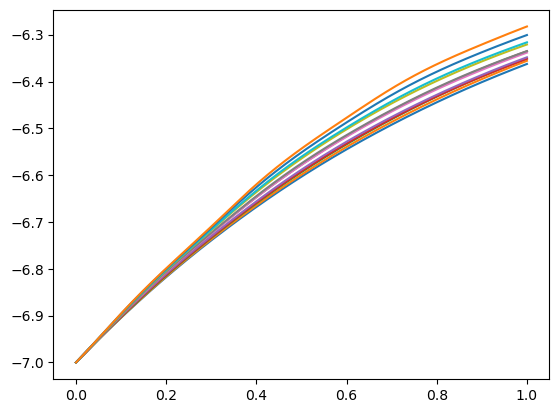

In [10]:
for i = 1:12
    plt = plot(T, mean_QC_sigmaz[i], label=L"N_{ES} = "*string((2*i-1)))
end

# Plot the derivatives of QC/CS/Independent case

In [11]:
length(var_FF_diff_mean_σz_mpc_rep)

25

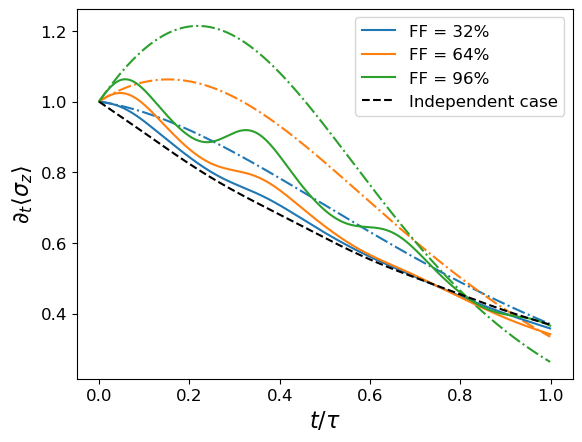

In [27]:
close("all")
figure()

PyPlot.rc("font", size = 12)

# CS
colorz = String[]
for i = 8:8:length(var_FF_diff_mean_σz_mpc_rep)
    plt = plot(T[1:end-1], var_FF_diff_mean_σz_mpc_rep[i], linestyle="-.")
    push!(colorz, plt[1].get_color())
end

# QC
counter = 1
for i = 4:4:length(mean_QC_sigmaz)#2:2:length(mean_QC_sigmaz)
    plot(T[1:end-1], diff(mean_QC_sigmaz[i])./Tstep, label="FF = "*string(Integer(i*2/N*100))*"%", color=colorz[counter])
    counter += 1
end

# Independent case
plot(T[1:end-1], diff(mean_QC_sigmaz[1])./Tstep, label="Independent case", linestyle="--", color = "black")

xlabel(L"t/\tau", fontsize=16)
ylabel(L"\partial_t\langle\sigma_z\rangle", fontsize=16)
legend()
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Vary_FF_Decay_rateMGT.pdf", bbox_inches="tight")
pygui(false);
#pygui(true); show()

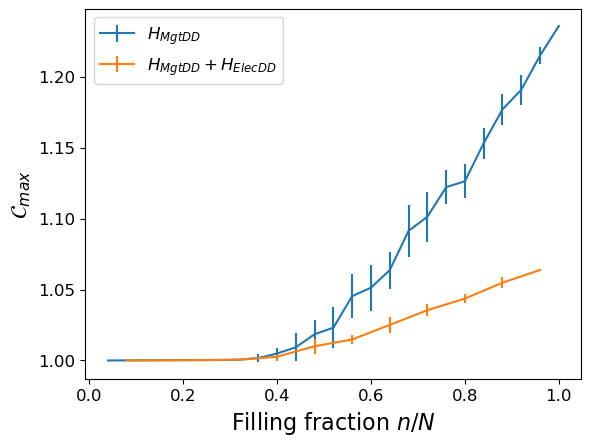

In [ ]:
close("all")
figure()

errorbar([i for i=1:N]./N, [var_FF_max_diff_mean_σz_mpc_rep[i] for i = 1:N]./var_FF_diff_mean_σz_mpc_rep[1][1], yerr=std_var_FF_max_diff_mean_σz_mpc_rep./var_FF_diff_mean_σz_mpc_rep[1][1], label=L"H_{MgtDD}")
errorbar([i for i=2:2:N]./N, var_FF_max_diff_mean_σz./var_FF_diff_mean_σz_mpc_rep[1][1], yerr=std_var_FF_max_diff_mean_σz./var_FF_diff_mean_σz_mpc_rep[1][1], label=L"H_{MgtDD}+H_{ElecDD}")

xlabel(L"Filling fraction $n/N$", fontsize=16)
ylabel(L"\mathcal{C}_{max}", fontsize=16) #L"max(\Gamma(t))/\gamma_0^{idp}
#title(L"Maximum decay rate of $<\sigma_z>$ for varying FF of the lattice with MPC computations")


legend()
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/FF_max_slope_ElecDD_phi_$(phi_init)_theta_$(round(theta_init, digits=1))_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")

pygui(false); gcf();
#pygui(true); show()



In [14]:
# Save data
#save_object("FF_Lattice_Kumlin_max_decay.jld2", [var_FF_diff_mean_σz_mpc_rep, std_var_FF_diff_mean_σz_mpc_rep, var_FF_max_diff_mean_σz_mpc_rep, std_var_FF_max_diff_mean_σz_mpc_rep])

In [15]:
# Load data
#var_FF_diff_mean_σz_mpc_rep, std_var_FF_diff_mean_σz_mpc_rep, var_FF_max_diff_mean_σz_mpc_rep, std_var_FF_max_diff_mean_σz_mpc_rep = load_object("FF_Lattice_Kumlin_max_decay.jld2");

# Initial Slope

In [16]:
@load "VarFF_InitSlope_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2)).jld2" var_FF_diff_mean_σz std_var_FF_diff_mean_σz;

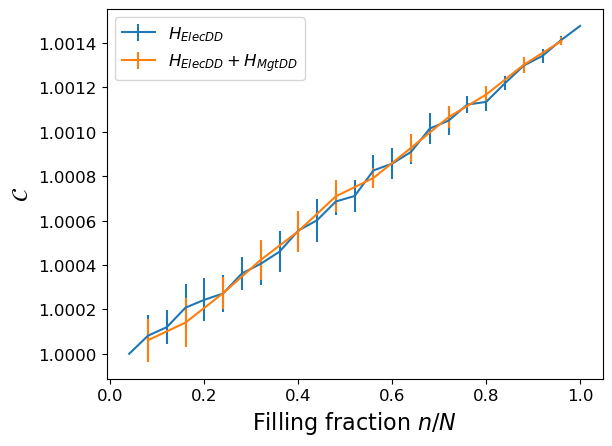

In [17]:
close("all")
figure()

PyPlot.rc("font", size = 12)

errorbar([i for i=1:N]./N, [var_FF_diff_mean_σz_mpc_rep[i][1] for i=1:N]./var_FF_diff_mean_σz_mpc_rep[1][1], yerr=[std_var_FF_diff_mean_σz_mpc_rep[i][1]./var_FF_diff_mean_σz_mpc_rep[1][1] for i=1:N], label=L"H_{ElecDD}")
errorbar([i for i=2:2:N]./N, var_FF_diff_mean_σz./var_FF_diff_mean_σz_mpc_rep[1][1], yerr=std_var_FF_diff_mean_σz./var_FF_diff_mean_σz_mpc_rep[1][1], label=L"H_{ElecDD}+H_{MgtDD}")

xlabel(L"Filling fraction $n/N$", fontsize=16)
ylabel(L"\mathcal{C}", fontsize=16) #L"\partial_t\langle\sigma_z\rangle/\gamma_0^{idp}
#title(L"Initial decay rate of $<\sigma_z>$ for varying FF of the lattice with MPC computations")

#axhline(1, color="grey", linestyle="--")
#axvline(0.5, color="grey", linestyle="--")

legend()

#savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/FF_initial_slope_ElecDD_phi_$(phi_init)_theta_$(round(theta_init, digits=1))_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")

pygui(false); #gcf()